In [1]:
from model_builder import ModelBuilder
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
import os
from model_utils import *
import scipy.stats as stats 
import numpy as np
import random
import statsmodels.stats.api as sms
from statsmodels.stats.multitest import multipletests

## Multi-Task Modeling Playground

The goal of this notebook is to prototype the modeling process for the team ingredient horse race project on the multi-task data.

For *each task* ...

We want to understand the effect of different "ingredients of a team" (Composition, Task, and Conversation) on its ultimate performance.

Team Composition:
- ['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR', 'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level', 'gender', 'marital_status', 'political_party', 'race']
- Number of players: 'playerCount'

Task Features:
- Need to append from the Task Map
- ['complexity', 'task']

Conversation Features (All)
- Everything else that is NOT an ID or a dependent variable

# Read and Preprocess Data
The function below reads in the dataframe and preprocesses each group of features:

- Composition
- Task
- Conversation

And also parses out the possible dependent variables.

In [2]:
def drop_invariant_columns(df):
    """
    Certain features are invariant throughout the training data (e.g., the entire column is 0 throughout).

    These feature obviously won't be very useful predictors, so we drop them.
    
    This function works by identifying columns that only have 1 unique value throughout the entire column,
    and then dropping them.

    @df: the dataframe containing the features (this should be X).
    """
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    return(df.drop(cols_to_drop, axis=1))


In [3]:
def read_and_preprocess_data(path, min_num_chats):
    conv_data  = pd.read_csv(path)

    # Fill NA with mean
    conv_data.fillna(conv_data.mean(), inplace=True) 

    # Filter this down to teams that have at least min_num of chats
    # Can also comment this out to re-run results on *all* conversations!
    conv_data = conv_data[conv_data["sum_num_messages"] >= min_num_chats]


    # Save the important information

    # DV
    dvs = conv_data[["score","speed","efficiency","raw_duration_min","default_duration_min"]]

    # Team Composition
    composition_colnames = ['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR',
                'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level',
                'gender', 'marital_status', 'political_party', 'race', 'playerCount']
    
    # Select columns that contain the specified keywords
    composition = conv_data[[col for col in conv_data.columns if any(keyword in col for keyword in composition_colnames)]]

    # Task
    task = conv_data[['task', 'complexity']].copy()

    task_map_path = '../utils/task_map.csv' # get task map
    task_map = pd.read_csv(task_map_path)

    task_name_mapping = {
        "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
        "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
        "Guess the Correlation": "Guessing the correlation",
        "Writing Story": "Writing story",
        "Room Assignment": "Room assignment task",
        "Allocating Resources": "Allocating resources to programs",
        "Divergent Association": "Divergent Association Task",
        "Word Construction": "Word construction from a subset of letters",
        "Whac a Mole": "Whac-A-Mole"
    }
    task.loc[:, 'task'] = task['task'].replace(task_name_mapping)
    task = pd.merge(left=task, right=task_map, on = "task", how='left')
    
    # Create dummy columns for 'complexity'
    complexity_dummies = pd.get_dummies(task['complexity'])
    task = pd.concat([task, complexity_dummies], axis=1)   
    task.drop(['complexity', 'task'], axis=1, inplace=True)

    # Conversation
    conversation = conv_data.drop(columns=list(dvs.columns) + list(composition.columns) + ['task', 'complexity', 'stageId', 'roundId', 'cumulative_stageId', 'gameId', 'message', 'message_lower_with_punc', 'speaker_nickname', 'conversation_num', 'timestamp'])
    conversation = drop_invariant_columns(conversation) # drop invariant conv features

    # additional preprocess --- get PC's of conversation to reduce dimensionality issues
    pca = PCA(n_components=5)
    pca_result = pca.fit_transform(conversation.transform(lambda x: (x - x.mean()) / x.std()))
    print("PCA explained variance:")
    print(np.sum(pca.explained_variance_ratio_))
    conversation = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    return composition, task, conversation, dvs

In [4]:
tiny_multitask = 'conv/multi_task_TINY_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage = 'conv/multi_task_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage_and_task = 'conv/multi_task_output_conversation_level_stageId_cumulative_within_task.csv'

In [5]:
# PARAMETERS
min_num_chats = 0
desired_target = "score"
data_path = "../output/"
output_path = "./results/multi_task_cumulative_stage/" + "min=" + str(min_num_chats) + "/" + desired_target + "/"

In [6]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + multitask_cumulative_by_stage_and_task, min_num_chats=min_num_chats)

# Number of points in dataset
len(conv_features)

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


KeyError: "['stageId', 'cumulative_stageId', 'message_lower_with_punc'] not found in axis"

In [ ]:
len(team_composition_features.columns)

33

In [ ]:
task_features

,Q1concept_behav,Q3type_1_planning,Q4type_2_generate,Q6type_5_cc,Q7type_7_battle,Q8type_8_performance,Q9divisible_unitary,Q10maximizing,Q11optimizing,Q13outcome_multip,...,Q22confl_tradeoffs,Q23ss_out_uncert,Q24eureka_question,Q2intel_manip_1,Q21intellective_judg_1,Q5creativity_input_1,Q25_type6_mixed_motive,High,Low,Medium
0,0.0,0.125,0.791667,0.041667,0.208333,0.086957,0.227273,0.583333,0.333333,0.208333,...,0.208333,1.000000,0.000,0.037500,0.466667,0.758333,0,0,0,1
1,0.0,0.125,0.791667,0.041667,0.208333,0.086957,0.227273,0.583333,0.333333,0.208333,...,0.208333,1.000000,0.000,0.037500,0.466667,0.758333,0,0,0,1
2,0.0,0.125,0.791667,0.041667,0.208333,0.086957,0.227273,0.583333,0.333333,0.208333,...,0.208333,1.000000,0.000,0.037500,0.466667,0.758333,0,0,0,1
3,0.0,0.125,0.791667,0.041667,0.208333,0.086957,0.227273,0.583333,0.333333,0.208333,...,0.208333,1.000000,0.000,0.037500,0.466667,0.758333,0,0,0,1
4,0.0,0.125,0.791667,0.041667,0.208333,0.086957,0.227273,0.583333,0.333333,0.208333,...,0.208333,1.000000,0.000,0.037500,0.466667,0.758333,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,0.0,0.375,0.125000,0.130435,0.250000,0.125000,0.086957,0.541667,0.708333,0.875000,...,0.791667,0.875000,0.125,0.050000,0.970833,0.325000,0,0,0,1
1014,0.0,0.375,0.125000,0.130435,0.250000,0.125000,0.086957,0.541667,0.708333,0.875000,...,0.791667,0.875000,0.125,0.050000,0.970833,0.325000,0,0,0,1
1015,0.0,0.375,0.125000,0.130435,0.250000,0.125000,0.086957,0.541667,0.708333,0.875000,...,0.791667,0.875000,0.125,0.050000,0.970833,0.325000,0,0,0,1
1016,0.0,0.125,0.400000,0.360000,0.080000,0.040000,0.250000,0.160000,0.000000,0.000000,...,0.200000,0.363636,0.000,0.088000,0.096000,0.916000,0,0,0,1


# Set up X's and y's

In [ ]:
X_train = pd.concat([team_composition_features, task_features, conv_features], axis = 1)
y_train = targets

## Try LASSO/Ridge Regression, one Set of Features at a Time

Here, we want to implement *leave-one-out cross-validation*, and use Q^2 as our metric.



Two updates to make here:

1. For nested LASSO/Ridge models, add the ability to initialize the model using the previous weights
2. Visualize importance using another library, like SHAP

In [ ]:
# Note --- this uses k-fold cross-validation with k = 5 (the default)
# We are testing 10,000 different alphas, so I feel like this is an OK heuristic
def get_optimal_alpha(X_train, y_train, y_target, feature_columns_list, lasso):

    if(lasso == True):
        model = LassoCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
    else:
        model = RidgeCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
        
    return model.alpha_ # optimal alpha

In [ ]:
def fit_regularized_linear_model(X_train, y_train, y_target, feature_columns_list, lasso=True, tune_alpha=False, prev_coefs = None, prev_alpha = None):

    if not tune_alpha:
        alpha = 1.0
    if (prev_alpha is not None):
        alpha = prev_alpha # use previous alpha
        print("Setting alpha to previous...")
        print(alpha)
    else:
        # Hyperparameter tune the alpha
        alpha = get_optimal_alpha(X_train, y_train, y_target, feature_columns_list, lasso=True)

    if lasso:
        model = Lasso(alpha=alpha)
    else:
        model = Ridge(alpha=alpha)

    if(prev_coefs is not None): # set weights to previous coefficients
        print("Setting coefficients ....")
        model.coef_ = prev_coefs

        print(model.coef_)

    # Calculation of Q^2 metric
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    # Initialize a list to store coefficients
    coefficients_list = []

    # Leave one out -- iterate through the entire length of the dataset
    for i in range(len(y_train)):
        # Store the evaluation datapoint
        evaluation_X = X_train.iloc[[i]]
        evaluation_y = y_train.iloc[[i]][y_target]

        # Drop the ith datapoint (leave this one out)
        X_train_fold = X_train.drop(X_train.index[i])
        y_train_fold = y_train.drop(y_train.index[i])[y_target]

        # Fit the model
        model.fit(X_train_fold[feature_columns_list], y_train_fold)

        # Save the Prediction Error
        prediction = model.predict(evaluation_X[feature_columns_list])[0]
        squared_model_prediction_errors.append((evaluation_y - prediction) ** 2)

        # Save the Total Error for this fold
        squared_average_prediction_errors.append((evaluation_y - np.mean(y_train_fold)) ** 2)

        # Append the coefficients to the list
        coefficients_list.append(model.coef_)

    # Create a DataFrame with feature names as rows and iteration results as columns
    feature_coefficients = pd.DataFrame(coefficients_list, columns=feature_columns_list).T

    q_squared = 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))
    print("Q^2: " + str(q_squared))

    return model, q_squared, feature_coefficients


In [ ]:
def display_feature_coefficients(feature_coef_df):
    # Initialize a list to store DataFrames for each feature
    dfs = []

    # Iterate through the rows of the input DataFrame
    for feature_name, coefficients in feature_coef_df.iterrows():
        # Calculate the confidence interval without NaN values
        non_nan_coefficients = coefficients[~np.isnan(coefficients)]
        if len(non_nan_coefficients) == 0:
            # Handle the case where there are no valid coefficients
            continue

        mean_coef = non_nan_coefficients.mean()

        # Check if all coefficients in the row are the same
        if len(coefficients.unique()) == 1:
            # If all coefficients are the same, set the lower and upper CI to the mean
            confidence_interval = (mean_coef, mean_coef)
        else:
            std_error = non_nan_coefficients.sem()
            confidence_interval = stats.t.interval(0.95, len(non_nan_coefficients) - 1, loc=mean_coef, scale=std_error)

        # Create a DataFrame for the summary data
        temp_df = pd.DataFrame({
            "Feature": [feature_name],
            "Mean": [mean_coef],
            "Lower_CI": [confidence_interval[0]],
            "Upper_CI": [confidence_interval[1]]
        })

        # Append the temporary DataFrame to the list
        dfs.append(temp_df)

    # Concatenate all the DataFrames in the list into the final summary DataFrame
    summary_df = pd.concat(dfs, ignore_index=True)

    return summary_df

In [ ]:
def sort_by_mean_abs(df):
    return df.reindex(df["Mean"].abs().sort_values(ascending=False).index)

In [ ]:
# Go through the different types of features and fit models

# First, create a data structure that saves the result
result = {
    "model": [],
    "model_type": [],
    "features_included": [],
    "alpha": [],
    "q_squared": []
}

result_df = pd.DataFrame(result)

# Function to Run all Experiments in 1 Go

In [ ]:
def get_sample_with_replacement(df):
    num_rows = len(df)
    resampled_indices = pd.Series(range(num_rows)).sample(n=num_rows, replace=True).reset_index(drop=True)
    resampled_dataframe = df.iloc[resampled_indices]

    return resampled_dataframe

In [ ]:
def resample():
    total_data = pd.concat([X_train, y_train], axis = 1)
    resampled_data = get_sample_with_replacement(total_data)
    resampled_X_train = resampled_data[list(X_train.columns)]
    resampled_y_train = resampled_data[list(y_train.columns)]

    return resampled_X_train, resampled_y_train

In [202]:
def train_and_evaluate_three_models(random_seed):
    random.seed(random_seed)

    # Set up the dataset by drawing 1,000 samples
    resampled_X_train, resampled_y_train = resample()

    # Composition Features
    model_ridge_composition, mrc_q2, mrc_feature_coefficients = fit_regularized_linear_model(resampled_X_train, resampled_y_train, desired_target, team_composition_features.columns, lasso = False, tune_alpha = True)

    # Composition + Task (Map Only)
    task_map_path = '../utils/task_map.csv' # get task map
    task_map_columns = list(pd.read_csv(task_map_path).drop(["task"], axis = 1).columns)
    task_gen_comp_features = task_map_columns + list(team_composition_features.columns)
    model_ridge_taskgencomp, mrtgc_q2, mrtgc_feature_coefficients = fit_regularized_linear_model(resampled_X_train, resampled_y_train, desired_target, task_gen_comp_features, lasso = False, tune_alpha = True)

    # Composition + Task (Map + Complexity)
    task_comp_features = list(task_features.columns) + list(team_composition_features.columns)
    model_ridge_taskcomp, mrtc_q2, mrtc_feature_coefficients = fit_regularized_linear_model(resampled_X_train, resampled_y_train, desired_target, task_comp_features, lasso = False, tune_alpha = True)

    # Composition + Task + Conversation
    all_features = list(task_features.columns) + list(team_composition_features.columns) + list(conv_features.columns)
    model_ridge_all, mrall_q2, mrall_feature_coefficients = fit_regularized_linear_model(resampled_X_train, resampled_y_train, desired_target, all_features, lasso = False, tune_alpha = True)

    return mrc_q2, mrtgc_q2, mrtc_q2, mrall_q2

In [203]:
composition_only = []
composition_task_general = []
composition_task = []
all = []
N_ITERS = 20
random_seeds = [random.randint(1, 999999999) for i in range(N_ITERS)]

for seed in random_seeds: # bootstrap 20 times
    comp, taskgencomp, taskcomp, taskcompconv = train_and_evaluate_three_models(seed)
    composition_only.append(comp)
    composition_task_general.append(taskgencomp)
    composition_task.append(taskcomp)
    all.append(taskcompconv)

Q^2: 0.12948846787808654
Q^2: 0.24792021736817904
Q^2: 0.2509706911043057
Q^2: 0.23846567303484845
Q^2: 0.11767942256389075
Q^2: 0.24127706757284206
Q^2: 0.23861894799705863
Q^2: 0.2311439445418082
Q^2: 0.09831787441344075
Q^2: 0.21354914039515438
Q^2: 0.22439545000563887
Q^2: 0.21850594166791804
Q^2: 0.06584915698807381
Q^2: 0.0870000137435668
Q^2: 0.09128210375002754
Q^2: 0.0558728495809665
Q^2: 0.11383188836687619
Q^2: 0.2134480521561024
Q^2: 0.21038510700326307
Q^2: 0.19924451533330978
Q^2: 0.10120887920578947
Q^2: 0.24022548610423033
Q^2: 0.24072847015524135
Q^2: 0.23030422083981272
Q^2: 0.04457413159803092
Q^2: 0.04528654355784223
Q^2: 0.04543894817403471
Q^2: 0.034746432557306806
Q^2: 0.07257898086409309
Q^2: 0.10118494929226507
Q^2: 0.10260353067736638
Q^2: 0.0948352403168442
Q^2: 0.022748969210753756
Q^2: 0.025524832048803958
Q^2: 0.026330242618293087
Q^2: 0.02513184692845072
Q^2: 0.13311086336187927
Q^2: 0.23500162990897266
Q^2: 0.23529822598122374
Q^2: 0.22124335582293908
Q^

In [205]:
sms.DescrStatsW(composition_only).tconfint_mean()

(0.0723414203300617, 0.10880177101420084)

In [204]:
sms.DescrStatsW(composition_task_general).tconfint_mean()

(0.12447816659147048, 0.21027519418334906)

In [206]:
sms.DescrStatsW(composition_task).tconfint_mean()

(0.12677357841734982, 0.2134126703380959)

In [207]:
sms.DescrStatsW(all).tconfint_mean()

(0.11416571390718777, 0.20034515930388297)

In [231]:
def plot_means_with_confidence_intervals_and_ttests(observation_lists, labels, confidence_level=0.95, alpha=0.05):
    # Calculate means and confidence intervals
    means = [np.mean(observation) for observation in observation_lists]
    errors = [(sms.DescrStatsW(observation).tconfint_mean()[1] - sms.DescrStatsW(observation).tconfint_mean()[0]) / 2. for observation in observation_lists]
    colors = plt.cm.tab20(np.arange(len(labels)))

    # Plot the bar graph with error bars
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(means)), means, yerr=errors, align='center', alpha=0.7, ecolor='black', color=colors, capsize=10)

    # Add labels and title
    plt.xticks(range(len(means)), labels, rotation=45, ha="right")  # Rotate x-axis labels by 45 degrees
    plt.ylabel('Prediction Q^2', size = 16)
    plt.title('Predictive Power of Models; Pairwise t-test with B-H Correction', size = 18)

    # Perform pairwise t-tests
    p_values = []
    line_height = np.mean(max(observation_lists)) * 0.1
    for i in range(len(observation_lists)):
        for j in range(i + 1, len(observation_lists)):
            t_stat, p_value = stats.ttest_ind(observation_lists[i], observation_lists[j])
            p_values.append(p_value)

            # Draw horizontal bar between compared groups only if p-value is significant
            if p_value < alpha:
                line_y = max(means) + max(errors) + np.mean(max(observation_lists)) * 0.03 + (i + j) * line_height * 1.5  # Adjust the multiplier for better spacing
                plt.plot([i, j], [line_y, line_y], color='black')

                # Display significance stars based on p-value
                if p_value < 0.001:
                    significance_label = '***'
                elif p_value < 0.01:
                    significance_label = '**'
                elif p_value < 0.05:
                    significance_label = '*'
                else:
                    significance_label = 'n.s.'

                # Display significance labels on the plot
                plt.text((i + j) / 2, line_y + np.mean(max(observation_lists)) * 0.025, significance_label, ha='center', va='center')

    # Correct p-values for multiple comparisons using Benjamini-Hochberg procedure
    _, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

    # Show the plot
    plt.show()

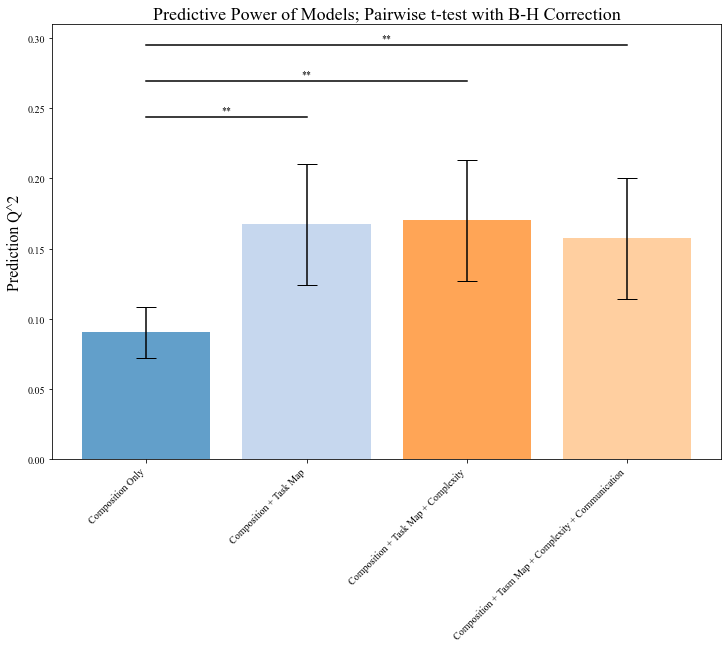

In [233]:
plot_means_with_confidence_intervals_and_ttests([composition_only, composition_task_general, composition_task, all], ["Composition Only", "Composition + Task Map", "Composition + Task Map + Complexity", "Composition + Tasm Map + Complexity + Communication"])